### Requirements

In [1]:
# base
import sys
import os
#cleaning
import re
import unicodedata
#manupulate numbers
import numpy as np
import pandas as pd
import random
#Graph
import seaborn  as sns
import matplotlib.pyplot as plt
from datetime import date,datetime,timedelta
#gcp
sys.path.append('..')
from settings import Settings
settings = Settings()
from clients.google import Gcp
gcp = Gcp(settings.EMBBEDINGS_BUCKET)
#modeling
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#ensamble
from sklearn.tree import DecisionTreeClassifier


# data

In [3]:
files = [
    'usem/1697445298_embedded_reviews_train.npz',
    'usem/1697445298_embedded_reviews_test.npz'
    ]

In [6]:
df = gcp.read_np_from_gcs(files[0], allow_pickle=True)
if df is not None and len(df) > 0:
    df_train = (
        pd.DataFrame({x: df[x] for x in df})
        .rename(columns={"index": "id"})
        .set_index("id")
    )
df = gcp.read_np_from_gcs(files[1], allow_pickle=True)
if df is not None and len(df) > 0:
    df_test = (
        pd.DataFrame({x: df[x] for x in df})
        .rename(columns={"index": "id"})
        .set_index("id")
    )
os.remove("file.npz")

In [7]:
df_train.columns

Index(['embedded_review', 'y'], dtype='object')

In [8]:
df_train

,embedded_review,y
id,,
270032,"[0.051702406, 0.0063196365, -0.0019192067, 0.0...","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
273058,"[0.026936151, -0.07401035, -0.02367169, 0.0012...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
272643,"[0.06126295, -0.005612696, 0.024638325, 0.0139...","[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
297102,"[-0.0500299, -0.09700354, 0.01769823, -0.02234...","[0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0]"
299760,"[0.04312534, -0.032369155, -0.023003675, 0.021...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
...,...,...
267064,"[0.024140796, -0.016030194, -0.032259483, -0.0...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
304503,"[-0.029617317, -0.04365659, 0.021056803, -0.05...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
297491,"[0.061326973, 0.013675633, 0.009585054, -0.001...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [13]:
len(df_train.embedded_review.values[0])

512

In [16]:
len(df_train.y.values[0])

8

In [9]:
df_test.columns

Index(['embedded_review', 'y'], dtype='object')

In [10]:
df_test

,embedded_review,y
id,,
280807,"[-0.019385519, 0.061420172, -0.034199018, 0.06...","[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
225426,"[0.016546639, 0.04594232, 0.035827015, -0.0418...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
258292,"[-0.062319446, 0.017953802, 0.0014271716, 0.02...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0]"
307508,"[0.021104338, -0.03740269, -0.04002929, -0.027...","[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
276805,"[-0.030853122, -0.01589446, -0.005709037, 0.01...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
...,...,...
224886,"[-0.013254025, -0.008982382, -0.014643711, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
261886,"[0.0005017076, -0.038983814, -0.026330085, 0.0...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
296273,"[0.045025535, -0.0063450993, -0.010803862, 0.0...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [15]:
len(df_test.embedded_review.values[0])

512

In [17]:
len(df_test.y.values[0])

8

# Sampling

In [11]:
X_train = np.array(list(df_train['embedded_review']))
X_test = np.array(list(df_test['embedded_review']))
y_train = np.array(list(df_train['y']))
y_test = np.array(list(df_test['y']))

In [21]:
X_test = np.array(list(df_train['embedded_review']))
X_train = np.array(list(df_test['embedded_review']))
y_test = np.array(list(df_train['y']))
y_train = np.array(list(df_test['y']))

# Modeling

## Decision tree

In [24]:
dt=DecisionTreeClassifier(random_state=2021,
                            class_weight='balanced')
#multilabel_dt = OneVsOneClassifier(dt)
multilabel_dt = OneVsRestClassifier(dt)

In [25]:
param_grid={
        'estimator__max_features':  ['sqrt', 'log2'],
        'estimator__max_depth' : range(5,25,5),
        'estimator__min_samples_leaf': range(5,30,5),
        'estimator__min_samples_split': range(5,26,5),
        'estimator__criterion' :['gini', 'entropy'],
       'estimator__ccp_alpha' : [0,0.001,0.002,0.003,0.004,0.005]
    }

In [ ]:
%%time
CV_dtc = GridSearchCV(
    estimator=multilabel_dt, 
    param_grid=param_grid, 
    scoring='f1', 
    cv= 5
)
CV_dtc.fit(X_train, y_train)

In [ ]:
print("Best: %f using %s" % (CV_dtc.best_score_, CV_dtc.best_params_))

Best: 0.688467 using {'estimator__criterion': 'entropy', 'estimator__max_depth': 15, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 0.001, 'estimator__min_samples_split': 20, 'estimator__n_estimators': 150}
Best: 0.689080 using {'estimator__criterion': 'entropy', 'estimator__max_depth': 15, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 0.001, 'estimator__min_samples_split': 15, 'estimator__n_estimators': 125}


In [ ]:
y_hat = CV_rfc.predict(X_test)
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,y_hat))

Accuracy for Random Forest on CV data:  0.6982472761724301
Accuracy for Random Forest on CV data:  0.6892468024632875


In [ ]:
values = list(df['Area Estandarizada'].unique())
CM = pd.DataFrame(confusion_matrix(y_test, y_hat), columns=values)
CM['Total_Real'] = CM.sum(axis=1)
CM = CM.append(CM.sum(axis=0), ignore_index=True)
CM.index = list(df['Area Estandarizada'].unique()) + ['Total_Predicción']
print(CM)

                   0    1   2    3    4    5    6    7    8  Total_Real
0                 33    0   2    3    0    7    0    5    1          51
1                  0   86   3    3    4   13    0    1    7         117
2                  0    2  34   11   10   11    1    9   12          90
3                  3    0   3  169   14   15    5   17   30         256
4                  1    8   2    7  161   42    2   13   34         270
5                  3    8   7    7   33  124    2   43   33         260
6                  0    2   0    0   14   20   93   15   12         156
7                  1    0   4    4    9   12    0  472   11         513
8                  0    7   1   11   22   33    4   18  302         398
Total_Predicción  41  113  56  215  267  277  107  593  442        2111
                   0    1   2    3    4    5    6    7    8  Total_Real
0                 32    0   1    7    1    3    0    6    1          51
1                  0   90   1    1    8   16    0    2    5     

Text(0.5, 1.0, 'Confusion Matrix Ariel v2')

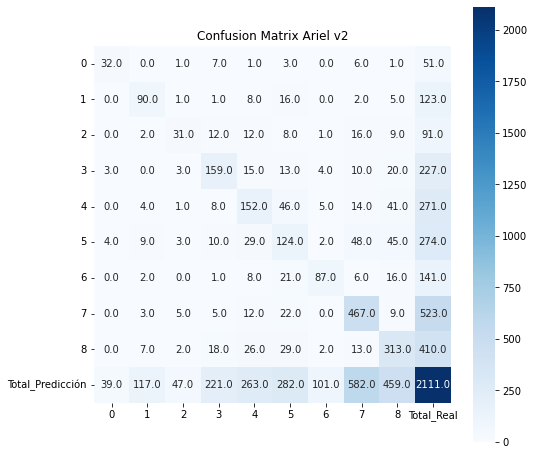

In [ ]:
# Draw the heatmap with the mask and correct aspect ratio
#sns.set(font_scale=2)
#plt.style.use("dark_background")
plt.figure(figsize= (8,8))
sns.heatmap(CM, cmap="Blues",#"RdYlBu",#"YlOrBr", 
    annot=True, square=True,
    #vmin=-1, vmax=1,
    #fmt="+.1f"
    fmt=".1f")
plt.title("Confusion Matrix Ariel v2")

In [ ]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.82      0.63      0.71        51
           1       0.77      0.73      0.75       123
           2       0.66      0.34      0.45        91
           3       0.72      0.70      0.71       227
           4       0.58      0.56      0.57       271
           5       0.44      0.45      0.45       274
           6       0.86      0.62      0.72       141
           7       0.80      0.89      0.85       523
           8       0.68      0.76      0.72       410

    accuracy                           0.69      2111
   macro avg       0.70      0.63      0.66      2111
weighted avg       0.69      0.69      0.68      2111



# report

In [ ]:
content = '@Channel :monkey_face: Ariel training update {0} \n \
the accuracy is about {1} \n \
:robot_face: [monkey_filter_history]'.format(
datetime.now().strftime("%Y-%m-%d"),#0
accuracy_score(y_test,y_hat)
)
print(content)

@Channel :monkey_face: Ariel training update 2022-05-28 
 the accuracy is about 0.6892468024632875 
 :robot_face: [monkey_filter_history]


In [ ]:
from utils import send2slack
if accuracy_score(y_test,y_hat)>0.7:
    send2slack(content)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bc2cb277-c3fd-470b-bd8b-89f9a40be78d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>